In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec

import cmocean
import cmocean.cm as cmo
import seaborn as sns

from scipy.interpolate import interp1d

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
df_doc = pd.read_csv('../Dissertation_projects/Data/TOC/TOC_GOM.csv', sep=',', index_col=0)

#make all BDL a 0 
df_doc.loc[df_doc['NPOC_uM'] == 'BLD', 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] == 'BLD', 'TN_uM'] = 0

df_doc.loc[df_doc['NPOC_uM'] < 0, 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] < 0, 'TN_uM'] = 0

#fix date time 
df_doc['date_time'] = pd.to_datetime(df_doc['Date'])
df_doc['Date'] = df_doc['date_time'].dt.date

df_doc['NPOC_uM'] = pd.to_numeric(df_doc['NPOC_uM'], errors='coerce')
df_doc['NPOC_uM'] = df_doc['NPOC_uM'].where(pd.notna(df_doc['NPOC_uM']), other=np.nan)

df_doc['TN_uM'] = pd.to_numeric(df_doc['TN_uM'], errors='coerce')
df_doc['TN_uM'] = df_doc['TN_uM'].where(pd.notna(df_doc['TN_uM']), other=np.nan)

df_doc['Time'] = pd.to_numeric(df_doc['Time'], errors='coerce')
df_doc['Time'] = df_doc['Time'].where(pd.notna(df_doc['Time']), other=np.nan)

df_doc['NPOC_uM'] = df_doc['NPOC_uM'].replace(0, np.nan)
df_doc['TN_uM'] = df_doc['TN_uM'].replace(0, np.nan)

df_doc['code'] = df_doc['Location'] + '_' + df_doc['Campaign']

df_doc = df_doc.drop(222101, axis=0)
df_doc = df_doc.drop(212211, axis=0)
df_doc = df_doc.drop(214311, axis=0)
df_doc = df_doc.drop(214317, axis=0)
df_doc = df_doc.drop(221710, axis=0)

In [3]:
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', sep=',', index_col=0)

#fix date time 
df_meta['date_time'] = pd.to_datetime(df_meta['Date'])
df_meta['Date'] = df_meta['date_time'].dt.date

df_meta['code'] = df_meta['Station'] + '_' + df_meta['Trip']

In [4]:

df_doc_pw = df_doc[df_doc['Type'] == 'PW']

df_doc_pw = df_doc_pw[df_doc_pw['code'] != "St.9_GOM2021"]
df_doc_pw = df_doc_pw[df_doc_pw['code'] != "St.5B_GOM2021"]
df_doc_pw = df_doc_pw[df_doc_pw['code'] != "St.4_GOM2021"]
df_doc_pw = df_doc_pw[df_doc_pw['code'] != "St.12_GOM22SU"]


df_doc_pw = df_doc_pw[df_doc_pw['NPOC_uM'] < 3500]
df_doc_pw

,Treatment,Campaign,Date,Location,NPOC Conc (mg/L),TN Conc (mg/L),Depth,Notes,Type,Time,Dil Factor,NPOC_uM,TN_uM,dil_fac,NPOC_uM_std,TN_uM_std,date_time,code
Sample ID,,,,,,,,,,,,,,,,,,
214300,P2F,GOM21FA,2021-10-25,St.5B,5.775000,0.69984375,0.00,NaN,PW,NaN,18.750000,481.250000,49.988839,18.750000,9.632900,1.051661,2021-10-25,St.5B_GOM21FA
214301,P2F,GOM21FA,2021-10-25,St.5B,4.738500,0.928875,0.35,NaN,PW,NaN,15.000000,394.875000,66.348214,15.000000,7.903982,1.395828,2021-10-25,St.5B_GOM21FA
214302,P2F,GOM21FA,2021-10-25,St.5B,6.355714,1.288928571,1.05,NaN,PW,NaN,42.857143,529.642857,92.066327,42.857143,10.601551,1.936884,2021-10-25,St.5B_GOM21FA
214303,P2F,GOM21FA,2021-10-25,St.5B,6.025714,1.291071429,1.75,NaN,PW,NaN,42.857143,502.142857,92.219388,42.857143,10.051100,1.940104,2021-10-25,St.5B_GOM21FA
214304,P2F,GOM21FA,2021-10-25,St.5B,4.357500,1.260675,2.45,NaN,PW,NaN,15.000000,363.125000,90.048214,15.000000,7.268461,1.894427,2021-10-25,St.5B_GOM21FA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224320,P2F,GOM22SU,2022-07-11,St.5B,6.057833,3.259133333,16.90,NaN,PW,NaN,12.666667,504.819444,232.795238,12.666667,9.973285,4.833053,2022-07-11,St.5B_GOM22SU
224321,P2F,GOM22SU,2022-07-11,St.5B,7.339067,3.444066667,18.90,NaN,PW,NaN,12.666667,611.588889,246.004762,12.666667,12.082638,5.107295,2022-07-11,St.5B_GOM22SU
224322,P2F,GOM22SU,2022-07-11,St.5B,8.562033,3.577066667,20.90,NaN,PW,NaN,12.666667,713.502778,255.504762,12.666667,14.096063,5.304524,2022-07-11,St.5B_GOM22SU


In [5]:
df_doc_pw['Location'].unique()

array(['St.5B', 'St.4', 'St.MK', 'St.7', 'St.13', 'St.14', 'St.9',
       'St.15', 'St.16', 'St.11', 'St.2', 'St.12'], dtype=object)

In [6]:
# Group by 'code' and calculate the mean while ignoring NaN values
grouped_df = df_meta.groupby('Station')[['Lat', 'Lon']].mean(numeric_only=True)

# Reset the index to make it a table
grouped_df.reset_index(inplace=True)
df_met = grouped_df

In [7]:
df_mobile_mud = pd.read_csv('../Dissertation_projects/Data/mobile_muds.csv', sep=',', index_col=0)

In [8]:
df_por = pd.read_csv('../Dissertation_projects/Data/Porosity/Porosity.csv', sep=',', index_col = 0)
df_por['code'] = df_por['Stn'] + '_' + df_por['camp']

df_p = df_por.groupby('code').agg({
    'Stn': 'first',
    'camp': 'first'
}).reset_index()

df_p.index = df_p['code']

In [9]:
# Group by 'code' and calculate the mean while ignoring NaN values
grouped_df = df_meta.groupby('code')[['Lat', 'Lon']].mean(numeric_only=True)

# Reset the index to make it a table
grouped_df.reset_index(inplace=True)
grouped_df.index = grouped_df['code']
df_met = grouped_df.drop('code', axis = 1)

In [10]:
interpolated_data = []

codes_list = df_por['code'].unique()

for code in codes_list:
    data_iron = df_doc_pw[df_doc_pw['code'] == code]
    data_por = df_por[df_por['code'] == code]
    depth_fe_max = data_iron['Depth'].max()
    depth_fe_min = data_iron['Depth'].min()
    depth_po_max = data_por['depth'].max()
    depth_po_min = data_por['depth'].min()
    
    data_iron_2 = data_iron
    data_iron = data_iron.loc[data_iron['Depth'] >= depth_po_min]
    data_iron = data_iron.loc[data_iron['Depth'] <= depth_po_max] 
    
    depth = data_iron['Depth']
    depth = np.asarray(depth, dtype=float).ravel()
    fe2 = data_iron['NPOC_uM']
    fe2 = np.asarray(fe2, dtype=float).ravel()
    tn = data_iron['TN_uM']
    tn = np.asarray(tn, dtype=float).ravel()
    doc_e = data_iron['NPOC_uM_std']
    doc_e = np.asarray(doc_e, dtype=float).ravel()
    tn_e = data_iron['TN_uM_std']
    tn_e = np.asarray(tn_e, dtype=float).ravel()
    stn = data_iron['Location']
    camp = data_iron['Campaign']
    
    depth_p = data_por['depth']
    depth_p = np.asarray(depth_p, dtype=float).ravel()
    porosity = data_por['porosity']
    porosity = np.asarray(porosity, dtype=float).ravel()
    
    valid_indices = np.isfinite(porosity)
    porosity = porosity[valid_indices]
    depth_p = depth_p[valid_indices]
    
    cs = interp1d(depth_p, porosity)
    por_interpolated = cs(depth)
    
    interpolated_data.append(pd.DataFrame({'por_interpolated': por_interpolated,
                                           'Depth': depth,
                                           'DOC': fe2,
                                           'TN': tn,
                                           'DOC_err':doc_e,
                                           'TN_err':tn_e,
                                           'code': code,
                                           'stn': stn, 
                                           'camp': camp
                                          }))

interpolated_df = pd.concat(interpolated_data, ignore_index=True)
interpolated_df.dropna(subset=['Depth'], inplace=True)
interpolated_df

,por_interpolated,Depth,DOC,TN,DOC_err,TN_err,code,stn,camp
0,0.897196,0.35,514.1250,69.010714,10.281966,1.415375,St.11_GOM2021,St.11,GOM2021
1,0.891846,1.05,409.1875,52.280357,8.183325,1.072244,St.11_GOM2021,St.11,GOM2021
2,0.879845,1.75,596.8750,42.192857,11.936880,0.865354,St.11_GOM2021,St.11,GOM2021
3,0.864441,3.15,1646.8750,56.126786,32.935788,1.151132,St.11_GOM2021,St.11,GOM2021
4,0.854063,3.85,1496.2500,239.142857,29.923445,4.904699,St.11_GOM2021,St.11,GOM2021
...,...,...,...,...,...,...,...,...,...
767,0.548052,24.70,499.3750,357.875000,9.963873,7.120938,St.5B_GOM22SP,St.5B,GOM22SP
768,0.636717,27.70,529.0625,383.875000,10.556218,7.638281,St.5B_GOM22SP,St.5B,GOM22SP
769,0.672394,30.70,640.1875,381.187500,12.773460,7.584806,St.5B_GOM22SP,St.5B,GOM22SP
770,0.632163,33.70,828.0000,369.437500,16.520824,7.351006,St.5B_GOM22SP,St.5B,GOM22SP


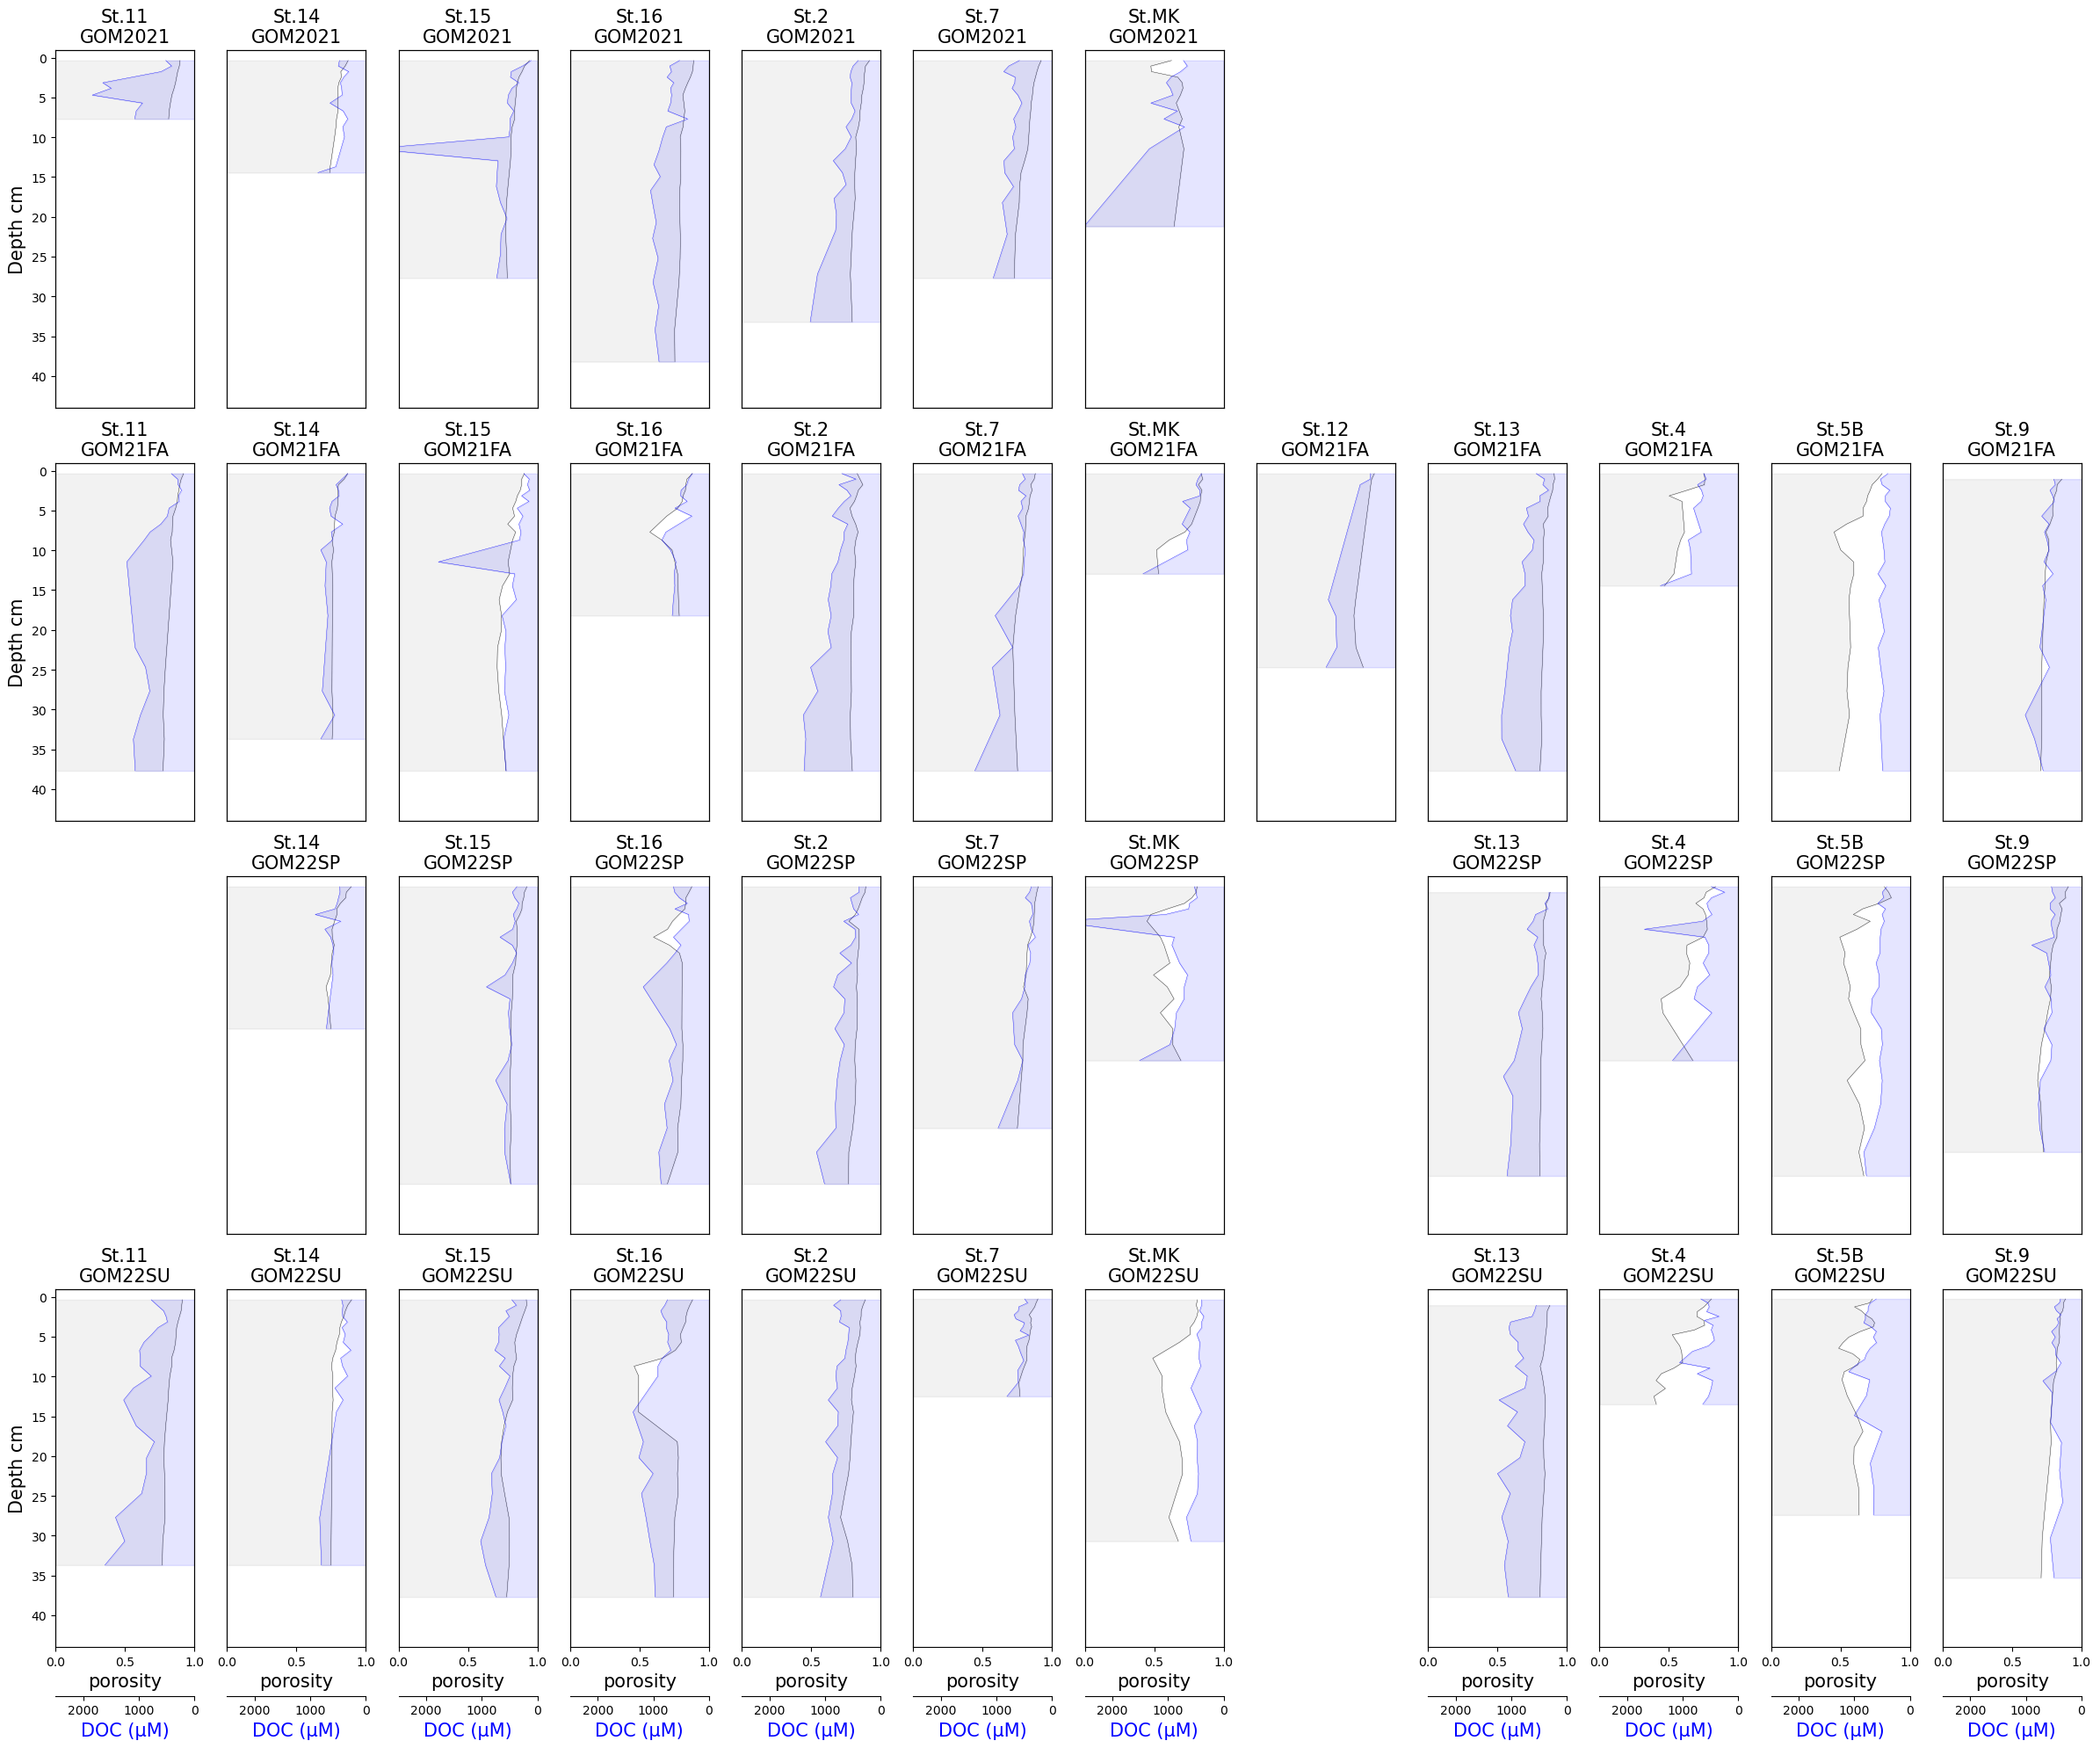

In [11]:
stations = interpolated_df['stn'].unique()
trips = interpolated_df['camp'].unique()

fig, axes = plt.subplots(len(trips), len(stations), figsize=(len(stations)*2, len(trips)*5))

for i, trip in enumerate(trips):
    for j, station in enumerate(stations):
        # Filter by trip and station
        #get data 
        data = interpolated_df[(interpolated_df['camp'] == trip) & (interpolated_df['stn'] == station)]
    
        #For Pore Waters 
        
        #get vars DOC 
        fe2 = data['DOC'] 
        fe2 = np.asarray(fe2, dtype=float).ravel()
        
        por = data['por_interpolated'] 
        por = np.asarray(por, dtype=float).ravel()
        
        depth = data['Depth'] #X var 
        depth = np.asarray(depth, dtype=float).ravel()

        if not data.empty:
            ax = axes[i, j]
            
            ax.plot(por, depth, c = 'black', lw = .25)
            ax.fill_betweenx(depth, por, color='grey', alpha=0.1)
            ax.set_title(f'{station}\n{trip}', size=15)
            ax.set_ylim(44, -1)
            ax.set_xlim(0, 1)
            
            ax3 = ax.twiny()
            ax3.plot(fe2, depth, c = 'blue', lw = .25)
            ax3.fill_betweenx(depth, fe2, color='blue', alpha=0.1)
            ax3.set_ylim(44, -1)
            ax3.set_xlim(2500, 0)
            
        else: 
            axes[i, j].axis('off')  
        if j == 0:
            axes[i,j].set_ylabel('Depth cm', size=15, c='black')
            axes[i,j].yaxis.set_tick_params(labelsize=10)
        else: 
            ax.set_ylabel('')
            ax.yaxis.set_ticklabels([])
            ax.set_yticks([])
        
        if i == 3:
            ax.set_xlabel('porosity', size=15, c='black')
            ax.xaxis.set_tick_params(labelsize=10)
            
            ax3.set_xlabel('DOC (\u03BCM)', size = 15, c= 'blue')
            ax3.xaxis.set_ticks_position('bottom')
            ax3.xaxis.set_label_position('bottom')
            ax3.spines['bottom'].set_position(('outward', 40))
            
        else: 
            ax.set_xlabel('')
            ax.xaxis.set_ticklabels([])
            ax.set_xticks([])
            
            
            ax3.set_xlabel('')
            ax3.xaxis.set_ticklabels([])
            ax3.set_xticks([])
            
            
plt.tight_layout()
fig.set_facecolor('w')
#plt.savefig(f'../Dissertation_projects/Figures/Pore_water_profiles/profile_carbon.png')
plt.show()

In [12]:
df_cal = interpolated_df
df_cal['sed_density_Gpercm3'] = 2.6

df_cal['depth_m'] = df_cal['Depth'] / 100

#fe uM to M 
df_cal['doc_mol_per_m3'] =  df_cal['DOC'] / 1000000 * 1000
df_cal['doc_mol_per_m3_vol'] =  df_cal['doc_mol_per_m3'] * df_cal['por_interpolated']

#fe uM to M 
df_cal['tn_mol_per_m3'] =  df_cal['TN'] / 1000000 * 1000
df_cal['tn_mol_per_m3_vol'] =  df_cal['tn_mol_per_m3'] * df_cal['por_interpolated']

#fe uM to M 
df_cal['doc_mol_per_m3_err'] =  df_cal['DOC_err'] / 1000000 * 1000
df_cal['doc_mol_per_m3_vol_err'] =  df_cal['doc_mol_per_m3_err'] * df_cal['por_interpolated']

#fe uM to M 
df_cal['tn_mol_per_m3_err'] =  df_cal['TN_err'] / 1000000 * 1000
df_cal['tn_mol_per_m3_vol_err'] =  df_cal['tn_mol_per_m3_err'] * df_cal['por_interpolated']

df_cal

,por_interpolated,Depth,DOC,TN,DOC_err,TN_err,code,stn,camp,sed_density_Gpercm3,depth_m,doc_mol_per_m3,doc_mol_per_m3_vol,tn_mol_per_m3,tn_mol_per_m3_vol,doc_mol_per_m3_err,doc_mol_per_m3_vol_err,tn_mol_per_m3_err,tn_mol_per_m3_vol_err
0,0.897196,0.35,514.1250,69.010714,10.281966,1.415375,St.11_GOM2021,St.11,GOM2021,2.6,0.0035,0.514125,0.461271,0.069011,0.061916,0.010282,0.009225,0.001415,0.001270
1,0.891846,1.05,409.1875,52.280357,8.183325,1.072244,St.11_GOM2021,St.11,GOM2021,2.6,0.0105,0.409187,0.364932,0.052280,0.046626,0.008183,0.007298,0.001072,0.000956
2,0.879845,1.75,596.8750,42.192857,11.936880,0.865354,St.11_GOM2021,St.11,GOM2021,2.6,0.0175,0.596875,0.525157,0.042193,0.037123,0.011937,0.010503,0.000865,0.000761
3,0.864441,3.15,1646.8750,56.126786,32.935788,1.151132,St.11_GOM2021,St.11,GOM2021,2.6,0.0315,1.646875,1.423626,0.056127,0.048518,0.032936,0.028471,0.001151,0.000995
4,0.854063,3.85,1496.2500,239.142857,29.923445,4.904699,St.11_GOM2021,St.11,GOM2021,2.6,0.0385,1.496250,1.277892,0.239143,0.204243,0.029923,0.025557,0.004905,0.004189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,0.548052,24.70,499.3750,357.875000,9.963873,7.120938,St.5B_GOM22SP,St.5B,GOM22SP,2.6,0.2470,0.499375,0.273683,0.357875,0.196134,0.009964,0.005461,0.007121,0.003903
768,0.636717,27.70,529.0625,383.875000,10.556218,7.638281,St.5B_GOM22SP,St.5B,GOM22SP,2.6,0.2770,0.529062,0.336863,0.383875,0.244420,0.010556,0.006721,0.007638,0.004863
769,0.672394,30.70,640.1875,381.187500,12.773460,7.584806,St.5B_GOM22SP,St.5B,GOM22SP,2.6,0.3070,0.640188,0.430458,0.381188,0.256308,0.012773,0.008589,0.007585,0.005100
770,0.632163,33.70,828.0000,369.437500,16.520824,7.351006,St.5B_GOM22SP,St.5B,GOM22SP,2.6,0.3370,0.828000,0.523431,0.369437,0.233545,0.016521,0.010444,0.007351,0.004647


In [13]:
codes_list

array(['St.11_GOM2021', 'St.14_GOM2021', 'St.15_GOM2021', 'St.16_GOM2021',
       'St.2_GOM2021', 'St.4_GOM2021', 'St.5B_GOM2021', 'St.7_GOM2021',
       'St.9_GOM2021', 'St.MK_GOM2021', 'St.11_GOM21FA', 'St.12_GOM21FA',
       'St.13_GOM21FA', 'St.14_GOM21FA', 'St.15_GOM21FA', 'St.16_GOM21FA',
       'St.2_GOM21FA', 'St.4_GOM21FA', 'St.5B_GOM21FA', 'St.7_GOM21FA',
       'St.9_GOM21FA', 'St.MK_GOM21FA', 'St.14_GOM22SP', 'St.2_GOM22SP',
       'St.4_GOM22SP', 'St.7_GOM22SP', 'St.9_GOM22SP', 'St.MK_GOM22SP',
       'St.11_GOM22SU', 'St.12_GOM22SU', 'St.13_GOM22SU', 'St.14_GOM22SU',
       'St.15_GOM22SU', 'St.16_GOM22SU', 'St.2_GOM22SU', 'St.4_GOM22SU',
       'St.5B_GOM22SU', 'St.7_GOM22SU', 'St.9_GOM22SU', 'St.MK_GOM22SU',
       'St.13_GOM22SP', 'St.16_GOM22SP', 'St.15_GOM22SP', 'St.5B_GOM22SP'],
      dtype=object)

In [14]:
Frames = []

for code in codes_list: 
    df_play = df_cal[df_cal['code'] == code] 

    # Create a row with NaN values
    new_row = pd.DataFrame([np.nan] * len(df_play.columns)).T

    # Set column names for the new row
    new_row.columns = df_play.columns
    new_row['depth_m'] = 0 
    new_row['doc_mol_per_m3_vol'] = 0 

    # Append the new row to the DataFrame
    df_play = pd.concat([pd.DataFrame(new_row), df_play], ignore_index=True)

    ds_fet = df_play.dropna(subset=['depth_m', 'doc_mol_per_m3_vol'])


    # Define the depth range you want to integrate over
    start_depth = 0
    stop_depth = .05

    # Interpolating concentration at depth 5 using linear interpolation
    fet_at_depth_5 = np.interp(stop_depth, ds_fet['depth_m'], ds_fet['doc_mol_per_m3_vol'])

    #add he depth 5 data  
    new_row.columns = ds_fet.columns
    new_row['depth_m'] = stop_depth
    new_row['doc_mol_per_m3_vol'] = fet_at_depth_5


    # Selecting data within the specified depth range
    selected_data_fet = ds_fet[(ds_fet['depth_m'] >= start_depth) & (ds_fet['depth_m'] <= stop_depth)]
    selected_data_fet = pd.concat([selected_data_fet, new_row])
    
    # Calculating the integral using the trapezoidal rule
    integral_fet = np.trapz(selected_data_fet['doc_mol_per_m3_vol'], selected_data_fet['depth_m']) / stop_depth

    dic = {'code':[code],
           'doc_mol_per_m3_0_to_5cm':[integral_fet]}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
    
stocks_pw_fe_5 = pd.concat(Frames, axis=0, ignore_index=False)

stocks_pw_fe_5

,doc_mol_per_m3_0_to_5cm
code,
St.11_GOM2021,0.923105
St.14_GOM2021,0.340952
St.15_GOM2021,0.328016
St.16_GOM2021,0.555662
St.2_GOM2021,0.436882
St.4_GOM2021,0.000000
St.5B_GOM2021,0.000000
St.7_GOM2021,0.600673
St.9_GOM2021,0.000000


In [15]:
Frames = []

for code in codes_list: 
    df_play = df_cal[df_cal['code'] == code] 

    # Create a row with NaN values
    new_row = pd.DataFrame([np.nan] * len(df_play.columns)).T

    # Set column names for the new row
    new_row.columns = df_play.columns
    new_row['depth_m'] = 0 
    new_row['doc_mol_per_m3_vol_err'] = 0 

    # Append the new row to the DataFrame
    df_play = pd.concat([pd.DataFrame(new_row), df_play], ignore_index=True)

    ds_fet = df_play.dropna(subset=['depth_m', 'doc_mol_per_m3_vol_err'])


    # Define the depth range you want to integrate over
    start_depth = 0
    stop_depth = .05

    # Interpolating concentration at depth 5 using linear interpolation
    fet_at_depth_5 = np.interp(stop_depth, ds_fet['depth_m'], ds_fet['doc_mol_per_m3_vol_err'])

    #add he depth 5 data  
    new_row.columns = ds_fet.columns
    new_row['depth_m'] = stop_depth
    new_row['doc_mol_per_m3_vol_err'] = fet_at_depth_5


    # Selecting data within the specified depth range
    selected_data_fet = ds_fet[(ds_fet['depth_m'] >= start_depth) & (ds_fet['depth_m'] <= stop_depth)]
    selected_data_fet = pd.concat([selected_data_fet, new_row])
    
    # Calculating the integral using the trapezoidal rule
    integral_fet = np.trapz(selected_data_fet['doc_mol_per_m3_vol_err'], selected_data_fet['depth_m']) / np.sqrt(len(selected_data_fet))

    dic = {'code':[code],
           'doc_mol_per_m3_0_to_5cm_error':[integral_fet]}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
    
stocks_pw_5_error = pd.concat(Frames, axis=0, ignore_index=False)

stocks_pw_5_error

,doc_mol_per_m3_0_to_5cm_error
code,
St.11_GOM2021,0.000326
St.14_GOM2021,0.000117
St.15_GOM2021,0.000113
St.16_GOM2021,0.000183
St.2_GOM2021,0.000144
St.4_GOM2021,0.000000
St.5B_GOM2021,0.000000
St.7_GOM2021,0.000200
St.9_GOM2021,0.000000


In [16]:
#TDN
Frames = []

for code in codes_list: 
    df_play = df_cal[df_cal['code'] == code] 

    # Create a row with NaN values
    new_row = pd.DataFrame([np.nan] * len(df_play.columns)).T

    # Set column names for the new row
    new_row.columns = df_play.columns
    new_row['depth_m'] = 0 
    new_row['tn_mol_per_m3_vol'] = 0 

    # Append the new row to the DataFrame
    df_play = pd.concat([pd.DataFrame(new_row), df_play], ignore_index=True)

    ds_fet = df_play.dropna(subset=['depth_m', 'tn_mol_per_m3_vol'])


    # Define the depth range you want to integrate over
    start_depth = 0
    stop_depth = .05

    # Interpolating concentration at depth 5 using linear interpolation
    fet_at_depth_5 = np.interp(stop_depth, ds_fet['depth_m'], ds_fet['tn_mol_per_m3_vol'])

    #add he depth 5 data  
    new_row.columns = ds_fet.columns
    new_row['depth_m'] = stop_depth
    new_row['tn_mol_per_m3_vol'] = fet_at_depth_5


    # Selecting data within the specified depth range
    selected_data_fet = ds_fet[(ds_fet['depth_m'] >= start_depth) & (ds_fet['depth_m'] <= stop_depth)]
    selected_data_fet = pd.concat([selected_data_fet, new_row])
    
    # Calculating the integral using the trapezoidal rule
    integral_fet = np.trapz(selected_data_fet['tn_mol_per_m3_vol'], selected_data_fet['depth_m']) / stop_depth 

    dic = {'code':[code],
           'tn_mol_per_m3_0_to_5cm':[integral_fet]}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
    
stocks_pw_tn_5 = pd.concat(Frames, axis=0, ignore_index=False)

stocks_pw_tn_5

,tn_mol_per_m3_0_to_5cm
code,
St.11_GOM2021,0.086652
St.14_GOM2021,0.093857
St.15_GOM2021,0.041944
St.16_GOM2021,0.102010
St.2_GOM2021,0.094289
St.4_GOM2021,0.000000
St.5B_GOM2021,0.000000
St.7_GOM2021,0.112095
St.9_GOM2021,0.000000


In [17]:
#TDN
Frames = []

for code in codes_list: 
    df_play = df_cal[df_cal['code'] == code] 

    # Create a row with NaN values
    new_row = pd.DataFrame([np.nan] * len(df_play.columns)).T

    # Set column names for the new row
    new_row.columns = df_play.columns
    new_row['depth_m'] = 0 
    new_row['tn_mol_per_m3_vol_err'] = 0 

    # Append the new row to the DataFrame
    df_play = pd.concat([pd.DataFrame(new_row), df_play], ignore_index=True)

    ds_fet = df_play.dropna(subset=['depth_m', 'tn_mol_per_m3_vol_err'])


    # Define the depth range you want to integrate over
    start_depth = 0
    stop_depth = .05

    # Interpolating concentration at depth 5 using linear interpolation
    fet_at_depth_5 = np.interp(stop_depth, ds_fet['depth_m'], ds_fet['tn_mol_per_m3_vol_err'])

    #add he depth 5 data  
    new_row.columns = ds_fet.columns
    new_row['depth_m'] = stop_depth
    new_row['tn_mol_per_m3_vol_err'] = fet_at_depth_5


    # Selecting data within the specified depth range
    selected_data_fet = ds_fet[(ds_fet['depth_m'] >= start_depth) & (ds_fet['depth_m'] <= stop_depth)]
    selected_data_fet = pd.concat([selected_data_fet, new_row])
    
    # Calculating the integral using the trapezoidal rule
    integral_fet = np.trapz(selected_data_fet['tn_mol_per_m3_vol_err'], selected_data_fet['depth_m']) / np.sqrt(len(selected_data_fet))

    dic = {'code':[code],
           'tn_mol_per_m3_0_to_5cm_error':[integral_fet]}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
    
stocks_pw_tn_5_error = pd.concat(Frames, axis=0, ignore_index=False)

stocks_pw_tn_5_error

,tn_mol_per_m3_0_to_5cm_error
code,
St.11_GOM2021,0.000031
St.14_GOM2021,0.000035
St.15_GOM2021,0.000015
St.16_GOM2021,0.000034
St.2_GOM2021,0.000032
St.4_GOM2021,0.000000
St.5B_GOM2021,0.000000
St.7_GOM2021,0.000038
St.9_GOM2021,0.000000


In [18]:
Frames = []

for code in codes_list: 
    df_play = df_cal[df_cal['code'] == code] 

    # Create a row with NaN values
    new_row = pd.DataFrame([np.nan] * len(df_play.columns)).T

    # Set column names for the new row
    new_row.columns = df_play.columns
    new_row['depth_m'] = 0 
    new_row['doc_mol_per_m3_vol'] = 0 

    # Append the new row to the DataFrame
    df_play = pd.concat([pd.DataFrame(new_row), df_play], ignore_index=True)

    ds_fet = df_play.dropna(subset=['depth_m', 'doc_mol_per_m3_vol'])

    # Define the depth range you want to integrate over
    start_depth = 0
    stop_depth = .25

    # Interpolating concentration at depth 5 using linear interpolation
    fet_at_depth_5 = np.interp(stop_depth, ds_fet['depth_m'], ds_fet['doc_mol_per_m3_vol'])

    #add he depth 5 data  
    new_row.columns = ds_fet.columns
    new_row['depth_m'] = stop_depth
    new_row['doc_mol_per_m3_vol'] = fet_at_depth_5


    # Selecting data within the specified depth range
    selected_data_fet = ds_fet[(ds_fet['depth_m'] >= start_depth) & (ds_fet['depth_m'] <= stop_depth)]
    selected_data_fet = pd.concat([selected_data_fet, new_row])
    
    # Calculating the integral using the trapezoidal rule
    integral_fet = np.trapz(selected_data_fet['doc_mol_per_m3_vol'], selected_data_fet['depth_m']) / stop_depth

    dic = {'code':[code],
           'doc_mol_per_m3_0_to_25cm':[integral_fet]}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
    
stocks_pw_fe_25 = pd.concat(Frames, axis=0, ignore_index=False)

stocks_pw_fe_25

,doc_mol_per_m3_0_to_25cm
code,
St.11_GOM2021,0.886844
St.14_GOM2021,0.474728
St.15_GOM2021,0.572516
St.16_GOM2021,0.678459
St.2_GOM2021,0.553022
St.4_GOM2021,0.000000
St.5B_GOM2021,0.000000
St.7_GOM2021,0.603919
St.9_GOM2021,0.000000


In [19]:
Frames = []

for code in codes_list: 
    df_play = df_cal[df_cal['code'] == code] 

    # Create a row with NaN values
    new_row = pd.DataFrame([np.nan] * len(df_play.columns)).T

    # Set column names for the new row
    new_row.columns = df_play.columns
    new_row['depth_m'] = 0 
    new_row['doc_mol_per_m3_vol'] = 0 

    # Append the new row to the DataFrame
    df_play = pd.concat([pd.DataFrame(new_row), df_play], ignore_index=True)

    ds_fet = df_play.dropna(subset=['depth_m', 'doc_mol_per_m3_vol'])

    # Define the depth range you want to integrate over
    start_depth = .05
    stop_depth = .25

    # Interpolating concentration at depth 5 using linear interpolation
    fet_at_depth_5 = np.interp(stop_depth, ds_fet['depth_m'], ds_fet['doc_mol_per_m3_vol'])

    #add he depth 5 data  
    new_row.columns = ds_fet.columns
    new_row['depth_m'] = stop_depth
    new_row['doc_mol_per_m3_vol'] = fet_at_depth_5


    # Selecting data within the specified depth range
    selected_data_fet = ds_fet[(ds_fet['depth_m'] >= start_depth) & (ds_fet['depth_m'] <= stop_depth)]
    selected_data_fet = pd.concat([selected_data_fet, new_row])
    
    # Calculating the integral using the trapezoidal rule
    integral_fet = np.trapz(selected_data_fet['doc_mol_per_m3_vol'], selected_data_fet['depth_m']) / stop_depth

    dic = {'code':[code],
           'doc_mol_per_m3_5_to_25cm':[integral_fet]}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
    
stocks_pw_fe_5_25 = pd.concat(Frames, axis=0, ignore_index=False)

stocks_pw_fe_5_25

,doc_mol_per_m3_5_to_25cm
code,
St.11_GOM2021,0.673083
St.14_GOM2021,0.393814
St.15_GOM2021,0.494293
St.16_GOM2021,0.551658
St.2_GOM2021,0.452830
St.4_GOM2021,0.000000
St.5B_GOM2021,0.000000
St.7_GOM2021,0.470172
St.9_GOM2021,0.000000


In [20]:
Frames = []

for code in codes_list: 
    df_play = df_cal[df_cal['code'] == code] 

    # Create a row with NaN values
    new_row = pd.DataFrame([np.nan] * len(df_play.columns)).T

    # Set column names for the new row
    new_row.columns = df_play.columns
    new_row['depth_m'] = 0 
    new_row['doc_mol_per_m3_vol_err'] = 0 

    # Append the new row to the DataFrame
    df_play = pd.concat([pd.DataFrame(new_row), df_play], ignore_index=True)

    ds_fet = df_play.dropna(subset=['depth_m', 'doc_mol_per_m3_vol_err'])

    # Define the depth range you want to integrate over
    start_depth = .05
    stop_depth = .25

    # Interpolating concentration at depth 5 using linear interpolation
    fet_at_depth_5 = np.interp(stop_depth, ds_fet['depth_m'], ds_fet['doc_mol_per_m3_vol_err'])

    #add he depth 5 data  
    new_row.columns = ds_fet.columns
    new_row['depth_m'] = stop_depth
    new_row['doc_mol_per_m3_vol_err'] = fet_at_depth_5


    # Selecting data within the specified depth range
    selected_data_fet = ds_fet[(ds_fet['depth_m'] >= start_depth) & (ds_fet['depth_m'] <= stop_depth)]
    selected_data_fet = pd.concat([selected_data_fet, new_row])
    
    # Calculating the integral using the trapezoidal rule
    integral_fet = np.trapz(selected_data_fet['doc_mol_per_m3_vol_err'], selected_data_fet['depth_m']) / np.sqrt(len(selected_data_fet))

    dic = {'code':[code],
           'doc_mol_per_m3_5_to_25cm_error':[integral_fet]}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
    
stocks_pw_fe_5_25_error = pd.concat(Frames, axis=0, ignore_index=False)

stocks_pw_fe_5_25_error

,doc_mol_per_m3_5_to_25cm_error
code,
St.11_GOM2021,0.001683
St.14_GOM2021,0.000718
St.15_GOM2021,0.000707
St.16_GOM2021,0.000754
St.2_GOM2021,0.000623
St.4_GOM2021,0.000000
St.5B_GOM2021,0.000000
St.7_GOM2021,0.000679
St.9_GOM2021,0.000000


In [21]:
#TDN
Frames = []

for code in codes_list: 
    df_play = df_cal[df_cal['code'] == code] 

    # Create a row with NaN values
    new_row = pd.DataFrame([np.nan] * len(df_play.columns)).T

    # Set column names for the new row
    new_row.columns = df_play.columns
    new_row['depth_m'] = 0 
    new_row['tn_mol_per_m3_vol'] = 0 

    # Append the new row to the DataFrame
    df_play = pd.concat([pd.DataFrame(new_row), df_play], ignore_index=True)

    ds_fet = df_play.dropna(subset=['depth_m', 'tn_mol_per_m3_vol'])

    # Define the depth range you want to integrate over
    start_depth = .05
    stop_depth = .25

    # Interpolating concentration at depth 5 using linear interpolation
    fet_at_depth_5 = np.interp(stop_depth, ds_fet['depth_m'], ds_fet['tn_mol_per_m3_vol'])

    #add he depth 5 data  
    new_row.columns = ds_fet.columns
    new_row['depth_m'] = stop_depth
    new_row['tn_mol_per_m3_vol'] = fet_at_depth_5


    # Selecting data within the specified depth range
    selected_data_fet = ds_fet[(ds_fet['depth_m'] >= start_depth) & (ds_fet['depth_m'] <= stop_depth)]
    selected_data_fet = pd.concat([selected_data_fet, new_row])
    
    # Calculating the integral using the trapezoidal rule
    integral_fet = np.trapz(selected_data_fet['tn_mol_per_m3_vol'], selected_data_fet['depth_m']) / stop_depth

    dic = {'code':[code],
           'tdn_mol_per_m3_5_to_25cm':[integral_fet]}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
    
stocks_pw_tn_5_25 = pd.concat(Frames, axis=0, ignore_index=False)

stocks_pw_tn_5_25

,tdn_mol_per_m3_5_to_25cm
code,
St.11_GOM2021,0.074930
St.14_GOM2021,0.133359
St.15_GOM2021,0.084135
St.16_GOM2021,0.226988
St.2_GOM2021,0.305640
St.4_GOM2021,0.000000
St.5B_GOM2021,0.000000
St.7_GOM2021,0.122774
St.9_GOM2021,0.000000


In [22]:
#TDN
Frames = []

for code in codes_list: 
    df_play = df_cal[df_cal['code'] == code] 

    # Create a row with NaN values
    new_row = pd.DataFrame([np.nan] * len(df_play.columns)).T

    # Set column names for the new row
    new_row.columns = df_play.columns
    new_row['depth_m'] = 0 
    new_row['tn_mol_per_m3_vol_err'] = 0 

    # Append the new row to the DataFrame
    df_play = pd.concat([pd.DataFrame(new_row), df_play], ignore_index=True)

    ds_fet = df_play.dropna(subset=['depth_m', 'tn_mol_per_m3_vol_err'])

    # Define the depth range you want to integrate over
    start_depth = .05
    stop_depth = .25

    # Interpolating concentration at depth 5 using linear interpolation
    fet_at_depth_5 = np.interp(stop_depth, ds_fet['depth_m'], ds_fet['tn_mol_per_m3_vol_err'])

    #add he depth 5 data  
    new_row.columns = ds_fet.columns
    new_row['depth_m'] = stop_depth
    new_row['tn_mol_per_m3_vol_err'] = fet_at_depth_5


    # Selecting data within the specified depth range
    selected_data_fet = ds_fet[(ds_fet['depth_m'] >= start_depth) & (ds_fet['depth_m'] <= stop_depth)]
    selected_data_fet = pd.concat([selected_data_fet, new_row])
    
    # Calculating the integral using the trapezoidal rule
    integral_fet = np.trapz(selected_data_fet['tn_mol_per_m3_vol_err'], selected_data_fet['depth_m']) / np.sqrt(len(selected_data_fet))

    dic = {'code':[code],
           'tdn_mol_per_m3_5_to_25cm_error':[integral_fet]}
        
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    Frames.append(slopes)
    
stocks_pw_tn_5_25_error = pd.concat(Frames, axis=0, ignore_index=False)

stocks_pw_tn_5_25_error

,tdn_mol_per_m3_5_to_25cm_error
code,
St.11_GOM2021,0.000192
St.14_GOM2021,0.000260
St.15_GOM2021,0.000129
St.16_GOM2021,0.000316
St.2_GOM2021,0.000432
St.4_GOM2021,0.000000
St.5B_GOM2021,0.000000
St.7_GOM2021,0.000182
St.9_GOM2021,0.000000


In [23]:
stocks_pw_fe = pd.concat([stocks_pw_fe_25, stocks_pw_fe_5_25, stocks_pw_fe_5, stocks_pw_tn_5, stocks_pw_tn_5, stocks_pw_tn_5_25, 
                         stocks_pw_tn_5_25_error, stocks_pw_fe_5_25_error,stocks_pw_tn_5_error, stocks_pw_5_error], axis=1)
stocks_pw_fe = stocks_pw_fe.drop('St.4_GOM2021', axis = 0)
stocks_pw_fe = stocks_pw_fe.drop('St.9_GOM2021', axis = 0)
stocks_pw_fe = stocks_pw_fe.drop('St.5B_GOM2021', axis = 0)
stocks_pw_fe = stocks_pw_fe.drop('St.12_GOM22SU', axis = 0)
stocks_pw_fe.to_csv('../Dissertation_projects/Data/Stats_data_sets/DOC_stocks.csv')
stocks_pw_fe

,doc_mol_per_m3_0_to_25cm,doc_mol_per_m3_5_to_25cm,doc_mol_per_m3_0_to_5cm,tn_mol_per_m3_0_to_5cm,tn_mol_per_m3_0_to_5cm,tdn_mol_per_m3_5_to_25cm,tdn_mol_per_m3_5_to_25cm_error,doc_mol_per_m3_5_to_25cm_error,tn_mol_per_m3_0_to_5cm_error,doc_mol_per_m3_0_to_5cm_error
code,,,,,,,,,,
St.11_GOM2021,0.886844,0.673083,0.923105,0.086652,0.086652,0.074930,0.000192,0.001683,0.000031,0.000326
St.14_GOM2021,0.474728,0.393814,0.340952,0.093857,0.093857,0.133359,0.000260,0.000718,0.000035,0.000117
St.15_GOM2021,0.572516,0.494293,0.328016,0.041944,0.041944,0.084135,0.000129,0.000707,0.000015,0.000113
St.16_GOM2021,0.678459,0.551658,0.555662,0.102010,0.102010,0.226988,0.000316,0.000754,0.000034,0.000183
St.2_GOM2021,0.553022,0.452830,0.436882,0.094289,0.094289,0.305640,0.000432,0.000623,0.000032,0.000144
St.7_GOM2021,0.603919,0.470172,0.600673,0.112095,0.112095,0.122774,0.000182,0.000679,0.000038,0.000200
St.MK_GOM2021,1.032982,0.904723,0.531959,0.047419,0.047419,0.053261,0.000103,0.001710,0.000016,0.000177
St.11_GOM21FA,0.724837,0.658888,0.273043,0.044475,0.044475,0.115609,0.000214,0.001210,0.000016,0.000095
St.12_GOM21FA,0.707881,0.282484,0.491910,0.075922,0.075922,0.076966,0.000176,0.000632,0.000035,0.000220
